Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 0.5628681249375161
Epoch 2/10, Loss: 0.5457582244823548
Epoch 3/10, Loss: 0.5381508256505311
Epoch 4/10, Loss: 0.5293398956835889
Epoch 5/10, Loss: 0.5229827063512638
Epoch 6/10, Loss: 0.5149947637402063
Epoch 7/10, Loss: 0.5097029589529062
Epoch 8/10, Loss: 0.5054554528843572
Epoch 9/10, Loss: 0.4999181701444012
Epoch 10/10, Loss: 0.4953592812133289
Test Accuracy: 75.21%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.42      0.52      2912
         1.0       0.77      0.90      0.83      6330

    accuracy                           0.75      9242
   macro avg       0.72      0.66      0.68      9242
weighted avg       0.74      0.75      0.73      9242



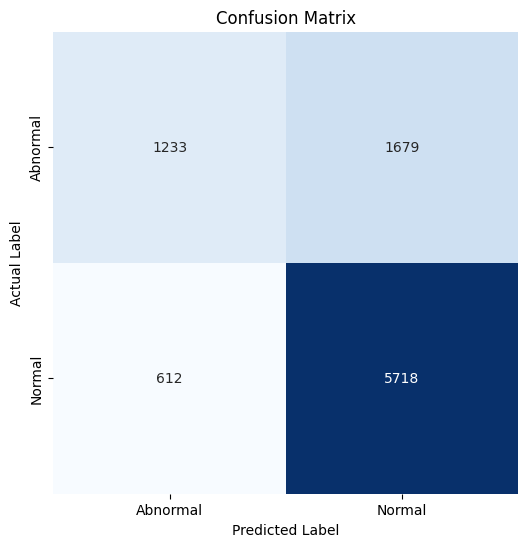

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from google.colab import drive

drive.mount('/content/drive')
directory_path = '/content/drive/My Drive/cybersummer'
file_path = f"{directory_path}/final_df.csv"
final_df = pd.read_csv(file_path)

# Preprocess the data
X = final_df.drop(columns=['Target', 'begin', 'end', 'id'])
y = final_df['Target']

# Initialize the scaler and scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data: Each 9-row block is a matrix for 5 seconds
num_rows = X_scaled.shape[0]
num_samples = num_rows // 9  # Number of 9-row samples

# Reshape X into (num_samples, 9, 23)
X_reshaped = X_scaled[:num_samples * 9].reshape(num_samples, 9, 23)

# Reshape for CNN: (num_samples, 1 channel, 9 rows, 23 features)
X_cnn_input = X_reshaped.reshape(num_samples, 1, 9, 23)

# Transform 'Target' into binary labels: 1 for 'normal' (5), 0 for 'abnormal' (others)
y_binary = final_df['Target'].map(lambda x: 1 if x == 5 else 0)

# Use y_binary for label extraction, take every 9th row's label for each matrix
y_labels = y_binary.iloc[::9].values[:num_samples]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn_input, y_labels, test_size=0.2, random_state=50)

# Convert to PyTorch tensors for CNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define CNN model
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))  # Single pooling layer to avoid zero dimension

        # Dynamically calculate the size after convolution and pooling
        self._calculate_conv_output_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.conv_output_size, 64)
        self.fc2 = nn.Linear(64, 1)  # Binary classification

    def _calculate_conv_output_size(self):
        dummy_input = torch.zeros(1, 1, 9, 23)
        x = self.pool(torch.relu(self.conv1(dummy_input)))
        self.conv_output_size = x.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = CNN2D()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the CNN
n_epochs = 10
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}")

# Testing the model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_test = (y_pred_test > 0.5).float()

# Calculate accuracy
accuracy = (y_pred_test == y_test_tensor).sum().item() / y_test_tensor.size(0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
y_pred_test_np = y_pred_test.numpy()
y_test_np = y_test_tensor.numpy()
print("Classification Report:")
print(classification_report(y_test_np, y_pred_test_np))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_np, y_pred_test_np)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()
